# "The Thera bank" Churn Prediction

In these notebook I create XGBoost model predicting customers willing to churn. Metric of my concern is Logloss.

# Load libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import ClusterCentroids

from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate
from sklearn import metrics

import os
import pickle
import sys

sys.path.append(os.path.join(os.environ['PWD'],'scripts'))
from Data_Prep import Data_Prep
from utils import get_metrics_score
from utils import make_confusion_matrix

from ray.tune.suggest.hyperopt import HyperOptSearch
import ray
from ray import tune

from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV

## Load and split dataset

In [4]:
train = pd.read_csv(os.path.join(os.environ['PWD'],'data/train.csv'))

X_train = train.drop('Attrition_Flag',axis=1)
y_train = train['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1}).astype('int')

test = pd.read_csv(os.path.join(os.environ['PWD'],'data/test.csv'))
X_test = test.drop('Attrition_Flag',axis=1)
y_test = test['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1}).astype('int')

## Load XGBoost

In [5]:
model_path = os.path.join(os.environ['PWD'],'models/xgboost_ros.pkl')
pickle_off = open(model_path, 'rb')
estimator = pickle.load(pickle_off)

## Calibration of XGBoost

In [6]:
def calibration_curve_plot(model,X,y):
    y_prob = model.predict_proba(X)[:, 1]
    prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=20)
    disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
    disp.plot()

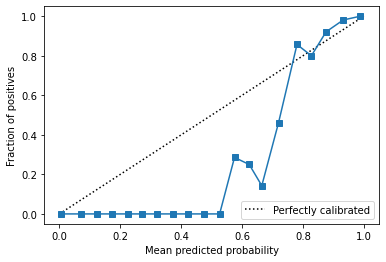

In [7]:
calibration_curve_plot(estimator,X_train,y_train)

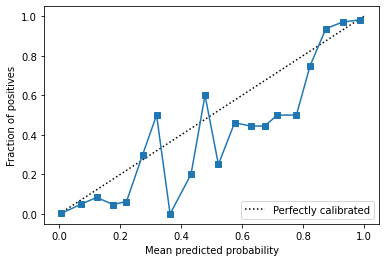

In [8]:
calibration_curve_plot(estimator,X_test,y_test)

It seems that our model is better calibrated on test data than train data.

## Calibrate XGBoost

In [9]:
estimator_calibrated = CalibratedClassifierCV(base_estimator=estimator, method='isotonic', n_jobs=-1)
estimator_calibrated.fit(X_train,y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from panda

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('dp', Data_Prep()),
                                                      ('ros',
                                                       RandomOverSampler()),
                                                      ('xgb',
                                                       XGBClassifier(base_score=0.5,
                                                                     booster='gbtree',
                                                                     colsample_bylevel=0.87,
                                                                     colsample_bynode=1,
                                                                     colsample_bytree=0.8,
                                                                     enable_categorical=False,
                                                                     eval_metric='logloss',
                                                                     gamma=0.232357276107194

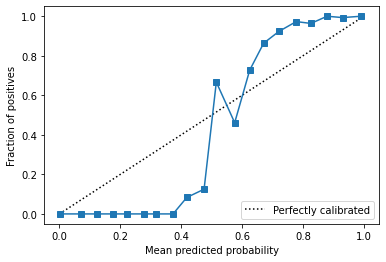

In [10]:
calibration_curve_plot(estimator_calibrated,X_train,y_train)

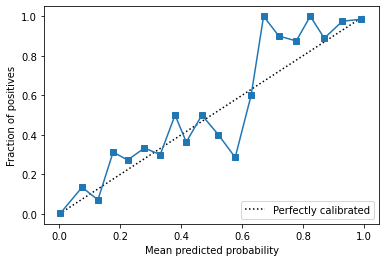

In [11]:
calibration_curve_plot(estimator_calibrated,X_test,y_test)

We get better calibration than before and calibration seems better for test dataset.

## Save model

In [12]:
model_path = os.path.join(os.environ['PWD'],'models/xgboost_calibrated.pkl')
pickling_on = open(model_path,"wb")
pickle.dump(estimator_calibrated, pickling_on)
pickling_on.close()
print('estimator pickled successfully!')

estimator pickled successfully!
